In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV 

# Question #1

# Notes
___
1. All of the dates have sufficient number of observations to resample them into 96 15-minute intervals, excluding:
* 1970-01-01 - the date when the recording is fisrt started, it has 76 intervals.
* 1970-04-13 - 76 intervals.
___

In [2]:
def load_logins_data():
    df = pd.read_json('raw_data/logins.json')
    df['logs'] = 1
    df.set_index('login_time',inplace=True)
    df = df.resample("15T").count()    
    df['date'] = df.index
    df['date'] = df['date'].dt.strftime('%Y-%m-%d')
    uniqe_dates = set(df['date'])
    # strftime('%Y-%m-%d')
    # .date

    return df[['date','logs']], list(uniqe_dates)

In [3]:
logins, unique_dates = load_logins_data()

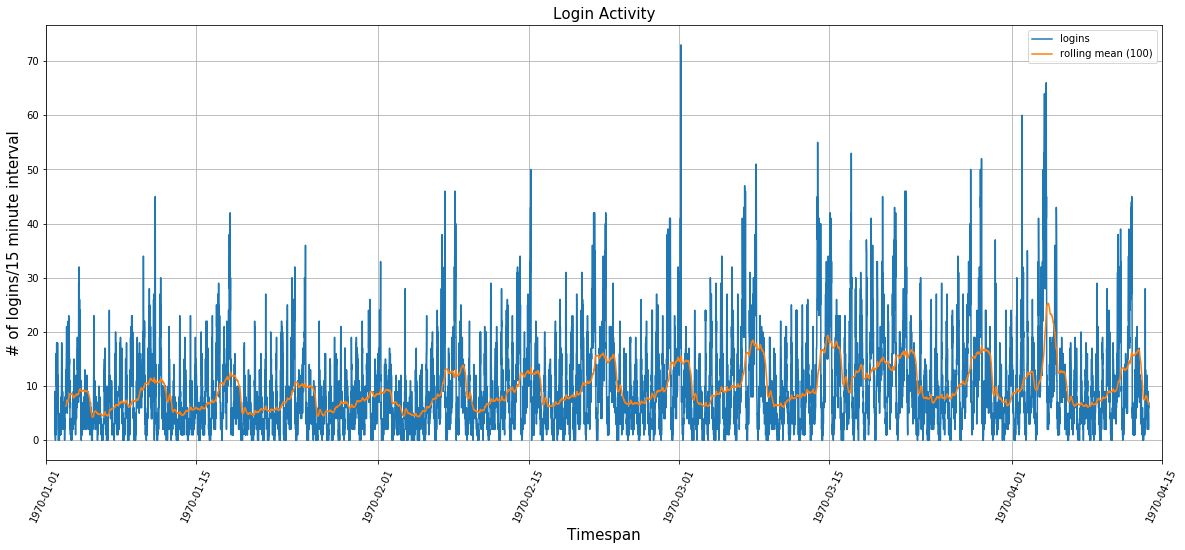

In [4]:
plt.figure(figsize=(20,8))
plt.plot(logins['logs'], label='logins')
plt.plot(logins['logs'].rolling(window=100).mean(), label='rolling mean (100)')
plt.title('Login Activity',size=15)
plt.ylabel('# of logins/15 minute interval',size=15)
plt.xlabel('Timespan',size=15)
plt.xlim([datetime.date(1970, 1, 1), datetime.date(1970, 4, 15)])
plt.xticks(rotation=65)
plt.grid()
plt.legend()
plt.show()

# Question #3

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).

What has been done so far:

1. nans are filled using appropriate techniques
2. target variable has been creates - 1 if driver is retained, 0 otherwise.
3. target variable is set to 1 if a driver was active over the last 30 days since the maximum date observed in the dataset.
4. data has been prepared for modeling, categorical features and target have been encoded, numerical features have been rescaled (standard scaler).
5. correaltion map has been created, except for one pair the features are not correltaed
6. gradient boosting classifier was chosen as a model.
7. features have been arranged by their importance


To do:
overlay average distance histograms of retained and lost users.

In [5]:
def load_ultimate_data(path):

    """
    load data, clean data, create label 
    """

    df = pd.read_json(path)

    df.avg_rating_of_driver.fillna(df.avg_rating_of_driver.mean(),inplace=True)
    df.avg_rating_by_driver.fillna(df.avg_rating_by_driver.mean(),inplace=True)
    df.phone.fillna(method='ffill',inplace=True)

    df['signup_date'] = pd.to_datetime(df['signup_date'])
    df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

    # threshol to 
    threshold = pd.Timestamp('2014-06-01')
    df['retained'] = df['last_trip_date']>threshold

    return df[['city', 'signup_date', 'phone', 'trips_in_first_30_days',  'ultimate_black_user', 
'avg_surge', 'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_of_driver', 'avg_rating_by_driver', 'last_trip_date', 'retained']]
    
ultimate = load_ultimate_data('raw_data/ultimate_data_challenge.json')

In [6]:
ml_columns = ['city', 'phone', 'ultimate_black_user','trips_in_first_30_days',  'avg_surge', 'surge_pct', 'weekday_pct','avg_dist', 'avg_rating_of_driver', 'avg_rating_by_driver','retained']

In [7]:
def cat_pre_process_data(df):

    """
    applies on the entire dataset
    prepare data for ml
    encode categorical data
    create target column
    """

    df = df[ml_columns]
    city = pd.get_dummies(df[['city']],drop_first=True)
    phone = pd.get_dummies(df[['phone']],drop_first=True)
    
    lbl_encoder = LabelEncoder()
    std_sclr = StandardScaler()
    
    ult_black = pd.DataFrame(lbl_encoder.fit_transform(ultimate[['ultimate_black_user']]),columns=['ultimate_black'])
    target = pd.DataFrame(lbl_encoder.fit_transform(ultimate[['retained']]),columns=['target'])
    

    df = pd.concat([city, phone, ult_black, ultimate[ml_columns[3:-1]], target], axis=1)
    return df

ml_ultimate = cat_pre_process_data(ultimate)

In [8]:
X = ml_ultimate[ml_ultimate.columns[:-1]]
y = ml_ultimate[['target']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [9]:
def scale_numerical_features(train,test,num_index):
    """
    applies on X_train and X_test portions
    df - pandas.DataFrame
    num_index - index of the df.columns where numerical features begin

    return X_train and X_test with scaled numerical features
    """
    num_features = train.columns[num_index:]
    cat_features = train.columns[:num_index]

    train_cat = train[cat_features]
    test_cat = test[cat_features]
    # reset indexes so concatenation can be performed
    train_cat.reset_index(inplace=True,drop=True)
    test_cat.reset_index(inplace=True,drop=True)

    scaler = StandardScaler()
    # train scaler only on the numerical data 
    scaler.fit(train[num_features])
    
    X_train = scaler.transform(train[num_features])
    X_test = scaler.transform(test[num_features])

    X_train = pd.DataFrame(X_train, columns=num_features)
    X_test = pd.DataFrame(X_test, columns=num_features)
    
    X_train = pd.concat([train_cat,X_train],axis=1)
    X_test = pd.concat([test_cat,X_test],axis=1)
    return X_train, X_test

X_train, X_test = scale_numerical_features(X_train,X_test, 4)

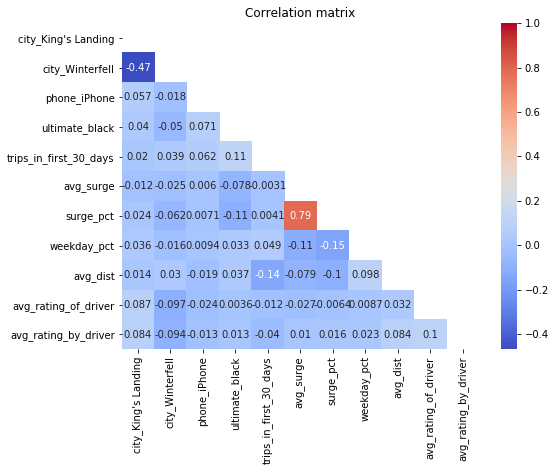

In [10]:
f, ax = plt.subplots(figsize=(8, 6))
matrix = np.triu(X_train.corr())
sns.heatmap(X_train.corr(), annot=True, mask=matrix, ax=ax, cmap='coolwarm')
ax.set_title('Correlation matrix')
plt.show()

In [23]:
xgb = GradientBoostingClassifier(n_estimators=100,max_depth=3)
xgb.fit(X_train,y_train)

logreg = LogisticRegression()
logreg.fit(X_train,y_train)

LogisticRegression()

In [24]:
def binary_classification_summary(model ,X_train, y_train, X_test, y_test):
    train_score = model.score(X_train,y_train)
    test_score = model.score(X_test,y_test)
    
    print("Model: {}".format(model))
    print('Train score: {}'.format(train_score))
    print('Test score: {}'.format(test_score))
    print('Classification report:')
    print(classification_report(y_test, model.predict(X_test)))

In [25]:
binary_classification_summary(xgb ,X_train, y_train, X_test, y_test)

Model: GradientBoostingClassifier()
Train score: 0.7956119402985075
Test score: 0.7887878787878788
Classification report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84     10466
           1       0.73      0.67      0.70      6034

    accuracy                           0.79     16500
   macro avg       0.77      0.76      0.77     16500
weighted avg       0.79      0.79      0.79     16500



In [26]:
binary_classification_summary(logreg ,X_train, y_train, X_test, y_test)

Model: LogisticRegression()
Train score: 0.7246865671641791
Test score: 0.7223636363636363
Classification report:
              precision    recall  f1-score   support

           0       0.75      0.85      0.80     10466
           1       0.66      0.50      0.57      6034

    accuracy                           0.72     16500
   macro avg       0.70      0.68      0.68     16500
weighted avg       0.71      0.72      0.71     16500



In [13]:
feature_importance = pd.DataFrame({'feature': X_train.columns
,'importance':xgb.feature_importances_})

feature_importance.sort_values(['importance'],ascending=False)

,feature,importance
10,avg_rating_by_driver,0.231008
6,surge_pct,0.195104
0,city_King's Landing,0.166168
7,weekday_pct,0.151186
2,phone_iPhone,0.096356
3,ultimate_black,0.071248
4,trips_in_first_30_days,0.037863
1,city_Winterfell,0.018647
8,avg_dist,0.018401
9,avg_rating_of_driver,0.010716


In [50]:
classifiers = [GradientBoostingClassifier(n_estimators=100,max_depth=3),LogisticRegression(),GaussianNB()]

result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc',
                                    'precision','recall',
                                    'precision score'])

for cls in classifiers:
    model = cls.fit(X_train, y_train)
    yproba = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    precision,recall,_ = precision_recall_curve(y_test,yproba)
    average_precision = average_precision_score(y_test,yproba)
    print('{} - DONE'.format(cls))
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc,
                                        'precision':precision,
                                        'recall':recall,
                                        'precision score':average_precision}, 
                                       ignore_index=True)


result_table.set_index('classifiers', inplace=True)                                               

GradientBoostingClassifier() - DONE
LogisticRegression() - DONE
GaussianNB() - DONE


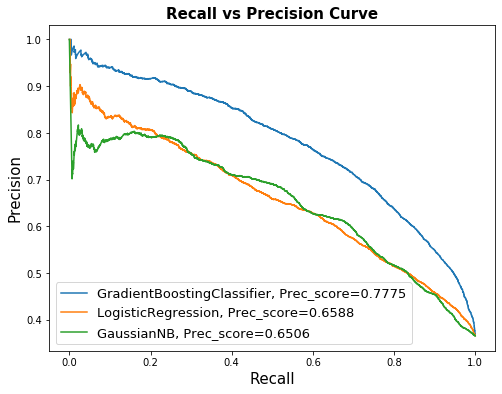

In [51]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['recall'],result_table.loc[i]['precision'],
            label="{}, Prec_score={:.4f}".format(i, result_table.loc[i]['precision score']))
    
plt.xlabel("Recall", fontsize=15)
plt.ylabel("Precision", fontsize=15)

plt.title('Recall vs Precision Curve', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower left')
#plt.savefig('images/recall_precision.png')
plt.show()

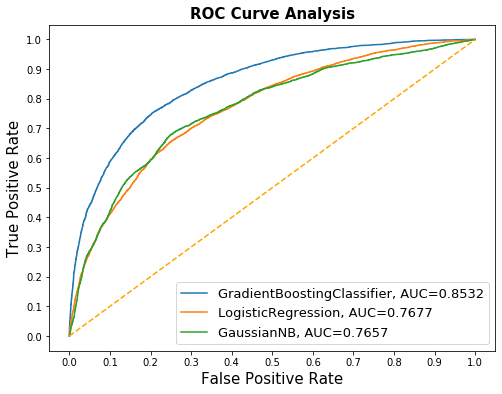

In [52]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.4f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')
#plt.savefig('images/ROC.png')
plt.show()


In [53]:
for algo, name in zip(classifiers, result_table.index):
    print("############## {} ##############".format(name))
    prediction = algo.predict(X_test)
    print(classification_report(y_test, prediction))

############## GradientBoostingClassifier ##############
              precision    recall  f1-score   support

           0       0.82      0.86      0.84     10466
           1       0.73      0.67      0.70      6034

    accuracy                           0.79     16500
   macro avg       0.77      0.76      0.77     16500
weighted avg       0.79      0.79      0.79     16500

############## LogisticRegression ##############
              precision    recall  f1-score   support

           0       0.75      0.85      0.80     10466
           1       0.66      0.50      0.57      6034

    accuracy                           0.72     16500
   macro avg       0.70      0.68      0.68     16500
weighted avg       0.71      0.72      0.71     16500

############## GaussianNB ##############
              precision    recall  f1-score   support

           0       0.80      0.76      0.78     10466
           1       0.61      0.67      0.64      6034

    accuracy                       